# pp cross-section extrapolation uncertainty

Here we estimate the extrapolated uncertainty of the pp inelastic cross-section at 100 TeV before and after the LHC era.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from iminuit import Minuit
from iminuit.cost import LeastSquares
from chromo.kinematics import FixedTarget, GeV, Momentum
from chromo.constants import nucleon_mass
from jacobi import propagate
from numpy.polynomial import Chebyshev
from IPython.display import display

We grab the raw data from the PDG website. Statistical and systematic uncertainties are added in quadrature.

In [2]:
def read(url):
    r = requests.get(url)
    tab = r.text
    xy = []
    skip = 11
    for line in tab.strip().split("\n"):
        if skip:
            skip -= 1
            continue
        items = line.split()
        xi = float(items[3])
        yi = float(items[4])
        yei = (0.5 * sum(float(i) ** 2 for i in items[5:9])) ** 0.5
        si = " ".join(items[9:11])
        if yei == 0.0:  # skip entries without uncertainties
            continue
        xy.append((xi, yi, yei, si))
    xy.sort(key=lambda p: p[0])
    return np.array(xy, dtype=np.dtype([("plab", "float"), ("sig", "float"), ("sige", "float"), ("source", "U32")]))

data = read("https://pdg.lbl.gov/2022/hadronic-xsections/rpp2022-pp_total.dat")

In [3]:
# put air shower measurements into separate array
air_shower_measurements = ("HONDA 93", "ABREU 12", "ABBASI 15", "BALTRUSAITIS 84")
mask = np.all([data["source"] != source for source in air_shower_measurements], axis=0)
accelerator = data[mask]
air_shower = data[~mask]

To estimate the extrapolation uncertainty, we fit a COMPETE-like model to the data (Patrignani C., et al., Particle Data Group
Chin. Phys. C, 40 (2016), Article 100001). The covariance matrix of the fit is propagated into an uncertainty on the cross-section at $\sqrt{s} = 100$ GeV. 

The original data is given in the lab frame and provides the proton momentum. We compute $\sqrt{s}$ from the momentum with the kinematic tools in Chromo for convenience.

To simulate the effect of the pre LHC era, we cut away all data points with $\sqrt s > 3$ TeV. This also removes cross-sections inferred from air shower data, but these do not affect our study anyway because of their relatively large uncertainties.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 93.98 (χ²/ndof = 0.7)      │             Nfcn = 1948              │
│ EDM = 0.000176 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 75.18 (χ²/ndof = 0.6)      │             Nfcn = 2590              │
│ EDM = 0.000118 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

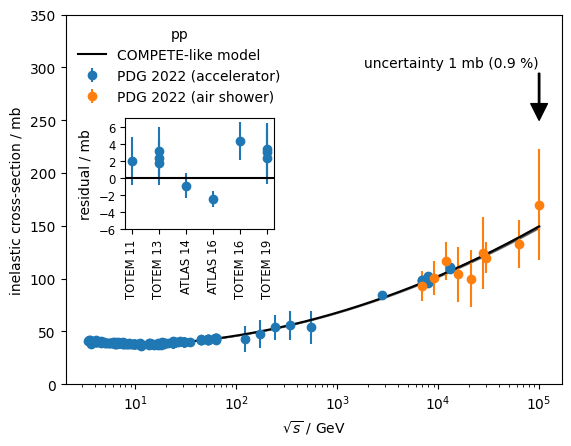

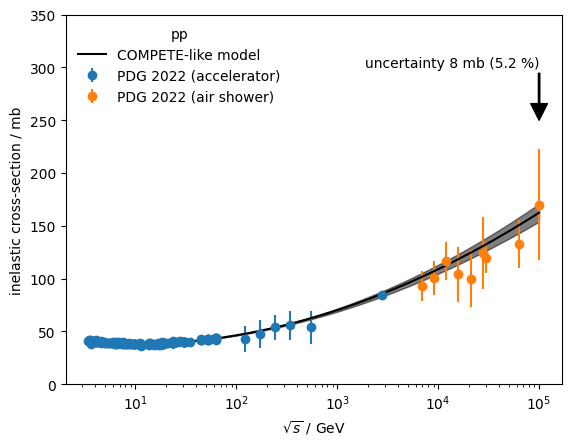

In [25]:
def compete(sqrts, h, m, pab, rab1, rab2, eta1, eta2):
    s = sqrts**2
    sabm = 2 * nucleon_mass + m
    x = s / sabm
    return h * np.log(x) ** 2 + pab + rab1 * x**-eta1 + rab2 * x**-eta2


sqrts = []
sig = []
sige = []
src = []

for plab, s, se, source in accelerator:
    if plab < 5:
        continue
    sqrts.append(FixedTarget(Momentum(plab * GeV), "p", "p").ecm)
    sig.append(s)
    sige.append(se)
    src.append(source)

sqrts = np.array(sqrts)
sig = np.array(sig)
sige = np.array(sige)
src = np.array(src)

cost = LeastSquares(sqrts, sig, sige, compete)
m = Minuit(cost, h=0.27, m=2.1, pab=34, rab1=13, rab2=7.4, eta1=0.451, eta2=0.549)
m.limits[:] = (0, None)
# some parameters need to be fixed, because they are not constrained by this data set
m.fixed["eta1", "eta2"] = True

for emax in (1e6, 3e3):
    cost.mask = sqrts < emax
    display(m.migrad(ncall=int(1e5)).fmin)
    val = m.values
    cov = m.covariance
    plt.figure()
    plt.errorbar(
        sqrts[cost.mask],
        sig[cost.mask],
        sige[cost.mask],
        fmt="o",
        label="PDG 2022 (accelerator)",
    )
    plt.errorbar(
        [FixedTarget(Momentum(plab * GeV), "p", "p").ecm for plab in air_shower["plab"]],
        air_shower["sig"],
        air_shower["sige"],
        fmt="o",
        label="PDG 2022 (air shower)",
    )
    msqrts = np.geomspace(10, 1e5, 1000)
    msig, cov_msig = propagate(lambda v: compete(msqrts, *v), val, cov)
    msige = np.diag(cov_msig) ** 0.5
    plt.plot(msqrts, msig, color="k", label="COMPETE-like model")
    plt.fill_between(msqrts, msig - msige, msig + msige, color="k", alpha=0.5)
    plt.semilogx()
    plt.xlabel(r"$\sqrt{s}$ / GeV")
    plt.ylabel("inelastic cross-section / mb")
    plt.legend(frameon=False, title="pp", loc="upper left")
    plt.ylim(0, 350)
    plt.annotate(
        f"uncertainty {msige[-1]:.0f} mb ({msige[-1]/msig[-1] * 100:.1f} %)",
        (1e5, 250), xytext=(1e5, 300),
        arrowprops={"facecolor": "k", "width": 1},
        ha="right"
    )

    if emax == 1e6:
        inax = plt.gca().inset_axes((0.12, 0.42, 0.3, 0.3))
        mask = 1e3 < sqrts
        sqrts_inset = sqrts[mask]
        src_inset = src[mask]
        x_inset = sqrts[mask]
        res_inset = sig[mask] - compete(sqrts_inset, *val)
        rese_inset = sige[mask]
        # sort all arrays according to publication year
        pub_year = [int(x.split()[1]) for x in src_inset]
        ind = np.argsort(pub_year)
        for x in (src_inset, sqrts_inset, x_inset, res_inset, rese_inset):
            x[:] = x[ind]
        inax.errorbar(src_inset, res_inset, rese_inset, fmt="o")
        inax.axhline(0, color="k")
        # inax.set_ylim(-5, 5)
        inax.set_ylabel("residual / mb")
        inax.set_yticks(np.linspace(-6, 6, 7))
        inax.tick_params("x", rotation=90)
        inax.tick_params(labelsize="small")

    plt.savefig(f"cross_section_extrapolation_uncertainty_{np.log10(emax):.0f}.pdf")